# Series de Tiempo

En este notebook abordaremos el problema de predicción a futuro (*forecasting*). No es un notebook exhaustivo, sino que se trata simplemente de un notebook para introducir algunas metodologías.

Cargamos los datos y preprocesamos para tener nuevamente la serie promedio semanal.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()


In [3]:
data = pd.read_csv('DS_Bitácora_41_Temperatura.csv')
data['fecha'] = pd.to_datetime({'year':data.anio, 'month': data.mes, 'day': data.dia})
data.head()

,dia,mes,anio,Tmax,Tmin,fecha
0,1,1,1959,25.6,11.6,1959-01-01
1,2,1,1959,26.2,16.4,1959-01-02
2,3,1,1959,27.3,18.8,1959-01-03
3,4,1,1959,25.4,16.6,1959-01-04
4,5,1,1959,21.6,10.7,1959-01-05


In [5]:
semanal = data.resample('W', on = 'fecha').mean()
semanal.Tmax[semanal.Tmax > 50] = np.nan
semanal.Tmin[semanal.Tmin > 50] = np.nan
semanal.drop(columns = ['dia', 'mes', 'anio'], inplace = True)
semanal['Tmean'] = (semanal.Tmax + semanal.Tmin)/2
semanal = semanal.interpolate()
semanal.head()

,Tmax,Tmin,Tmean
fecha,,,
1959-01-04,26.125000,15.850000,20.987500
1959-01-11,26.600000,12.785714,19.692857
1959-01-18,28.300000,16.885714,22.592857
1959-01-25,31.300000,16.400000,23.850000
1959-02-01,27.633333,16.014286,21.823810


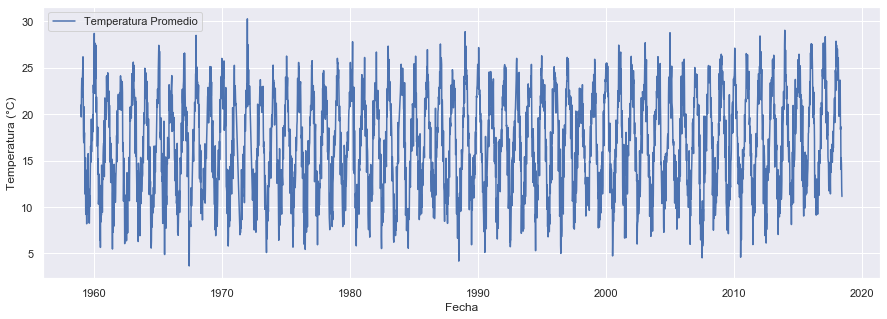

In [6]:
plt.figure(figsize = (15,5))
plt.plot(semanal.index, semanal.Tmean, label = 'Temperatura Promedio')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
# plt.xlim(datetime.date(1990,1,1), datetime.date(2018,1,1))
# plt.ylim(-10,40)
plt.legend()
plt.show()

## 1. Autocorrelación

Recomendamos fuertemente [este artículo](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/) para una mucho mejor exposición de este tema.

Como ya hemos visto, la correlación es una cuantificación de la relación entre el comportamiento de dos variables. En un lenguaje coloquial:
1. Cuanda ambas crecen y decrecen a la vez, decimos que están positivamente correlacionadas (valor cercano a 1).
1. Si una decrece y la otra crece, y viceversa, están negativamente correlacionadas (valor cercano a -1).
1. Y si no parece haber una relación entre su comportamiento, no están correlacionadas (valor alrededor de 0).

Vimos que hay más de una forma de calcular la correlación, la más conocida la correlación de Pearson o lineal.

En series de tiempo, el concepto de correlación aplica perfectamente. Dos series de tiempo están correlacionadas si su comportamiento en el tiempo es parecido (crecen y decrecen juntas) o anti-correlacionadas si una es máxima cuando la otra es mínima, y viceversa. También existe el concepto de autocorrelación, que es - a grosso modo - la correlación de una serie consigo misma. Pero toda variable correlacionada consigo misma da 1, por lo que estaría faltando algo. Lo que falta son los *lags*. Vamos a calcular la correlación con la serie de tiempo original y la misma serie desfasada o corrida en el tiempo. 

En la librería `statsmodel` esto lo logramos con la función `acf`. Como siempre, te recomendamos leer la documentación y ver bien los argumentos de esta función.


In [12]:
from statsmodels.tsa.stattools import acf

nlags =  52*20
autocorr = acf(semanal.Tmean, nlags = nlags)

In [13]:
autocorr.shape

(1041,)

Text(0.5, 0, 'lag')

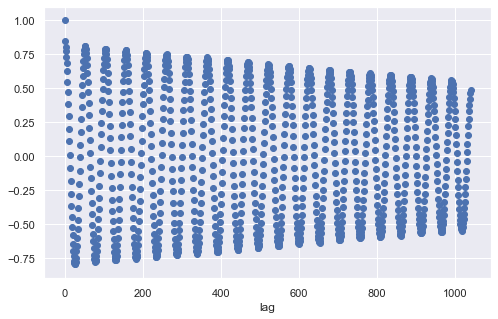

In [14]:
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')

A este gráfico a veces se lo suele llamar correlograma.

**Para pensar e investigar:** ¿por qué el primer valor es 1?¿Por qué va decreciendo en el tiempo?¿Qué nos puede decir eso con respecto al problema de predicción a futuro?

**Ejercicio:** leer la documentación e interpretar el siguiente gráfico.


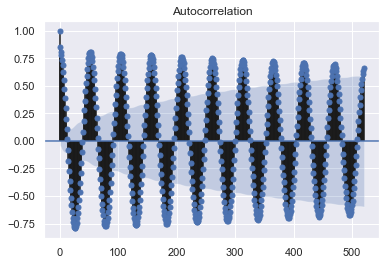

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(semanal.Tmean, lags = 52*10)
plt.show()

Es importante cuando se correlacionan series entre sí tener en cuenta la tendencia. Dos series con tendencias fuertes crecientes estarán trivialmente correlacionadas. Steven Skiena lo explica claramente en The Data Science Design Manual aplicado a series de tiempo de precios:

> *La otra corrección importante es la inflación. El valor en el tiempo del dinero implica que un dólar hoy es (generalmente) más valioso que un dólar al año a partir de ahora (...). Usar precios no ajustados por inflación en un modelo durante períodos de tiempo no-triviales es buscarse problemas. Un grupo de mis estudiantes una vez se entusiasmó mucho con la fuerte correlación observada entre los precios de unas acciones y los precios del petróleo durante un período de treinta años, y por eso intentaron usar los precios de las acciones en un modelo de predicción de productos. Pero ambos bienes tenían un precio en dólares, sin ningún ajuste a medida que se inflaban. La serie temporal de precios de esencialmente cualquier par de artículos se correlacionará fuertemente con el tiempo cuando no corrijas por inflación.*

## 2. Predicción a Futuro

### 2.1. One-Step Prediction

Vamos a entrenar un `RandomForestRegressor` para predecir el siguiente valor en la serie de tiempo semanal de temperatura. Utilizaremos los diez primeros años como conjunto de entrenamiento. Y los años 11 a 14 como evaluación. Para ello, tenemos que llevar los datos a la forma vista durante la presentación.

In [16]:
senial = semanal.Tmean
senial.head()

fecha
1959-01-04    20.987500
1959-01-11    19.692857
1959-01-18    22.592857
1959-01-25    23.850000
1959-02-01    21.823810
Freq: W-SUN, Name: Tmean, dtype: float64

En primer lugar, debemos definir cuántos valores *hacia atrás* tomaremos.

In [17]:
look_back = 52*2 # usamos dos anios de datos para predecir el valor siguiente

Creamos los `X` e `y` con ceros para luego llenar con los datos. Notar los `shape`

In [18]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(2998, 104) (2998,)


Llenamos los `X` e `y`

In [19]:
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [20]:
print(X)

[[20.9875     19.69285714 22.59285714 ... 21.02857143 19.42857143
  19.87142857]
 [19.69285714 22.59285714 23.85       ... 19.42857143 19.87142857
  24.07142857]
 [22.59285714 23.85       21.82380952 ... 19.87142857 24.07142857
  22.39285714]
 ...
 [13.04285714 11.04285714  9.12857143 ... 18.34285714 18.65
  14.05      ]
 [11.04285714  9.12857143 11.35714286 ... 18.65       14.05
  15.29285714]
 [ 9.12857143 11.35714286 10.51428571 ... 14.05       15.29285714
  14.54285714]]


In [21]:
print(y)

[24.07142857 22.39285714 24.14761905 ... 15.29285714 14.54285714
 11.93571429]


Es importante notar que el tiempo de la medición - fecha - ya no es parte de los datos.

Hacemos el train/test split. Esta parte puede ser confusa, por lo que presta atención a cómo lo hacemos.

In [22]:
N_train = 10*52 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 4*52 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(416, 104) (416,)
(208, 104) (208,)


Entrenamos

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

Graficamos la importancia de cada feature.

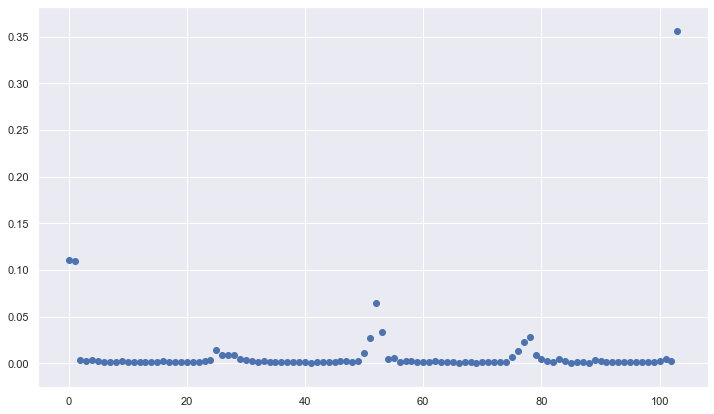

In [24]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
# for x in np.arange(3)*52:
#     plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

¿A qué atributos les da importancia? Interpretar. Hay dos líneas que puedes descomentar en la celda anterior para ayudarte.

Predecimos.

In [25]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

Y graficamos. Este gráfico también puede ser confuso, por lo que presta atención a cada línea. Si quieres, puedes ir comentando y descomentando cada línea para ver bien qué está haciendo y que el gráfico no quede tan sobrecargado.

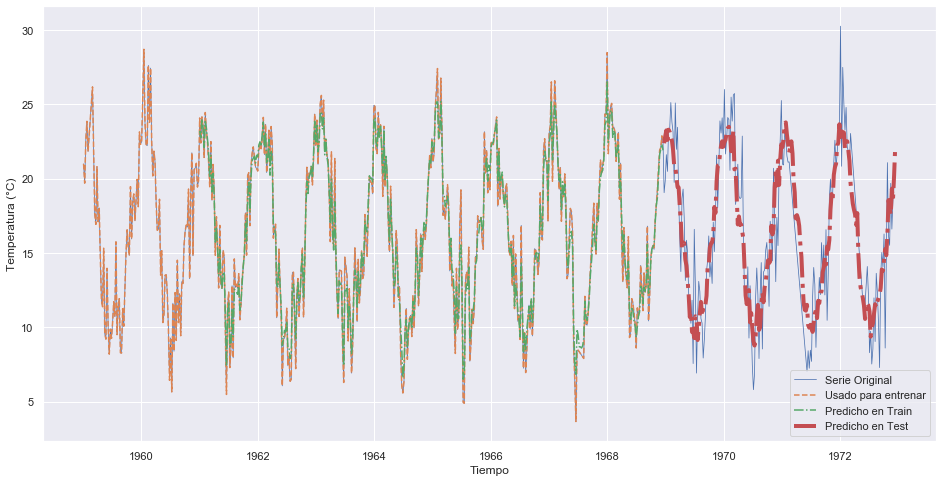

In [26]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.show()

¿Qué les parecen, visualmente, estos resultados?

Calculamos el error RMSE en train y test.

In [27]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 0.9168845000957381
Error en Test: 2.456918803408969


**Benchmark**: comparamos el error con el que habríamos obtenido si predecíamos copiando el valor de la fecha anterior.

In [28]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

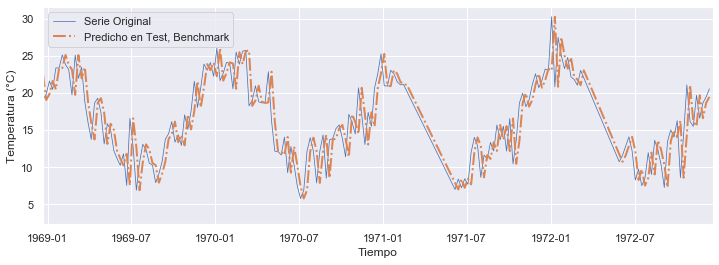

In [29]:
plt.figure(figsize=(12,4))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial.index[N_train+look_back], senial.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

In [30]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print(np.sqrt(MSE))

2.9813397301215194


Por lo que parece que, si bien no mucho, el modelo mejora la predicción por sobre el benchmark en el conjunto de test.

### 2.2. Multi-Step Prediction

Con el modelo ya entrenado, vamos a usar el método recursivo para hacer Multi-Step prediction.

In [31]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

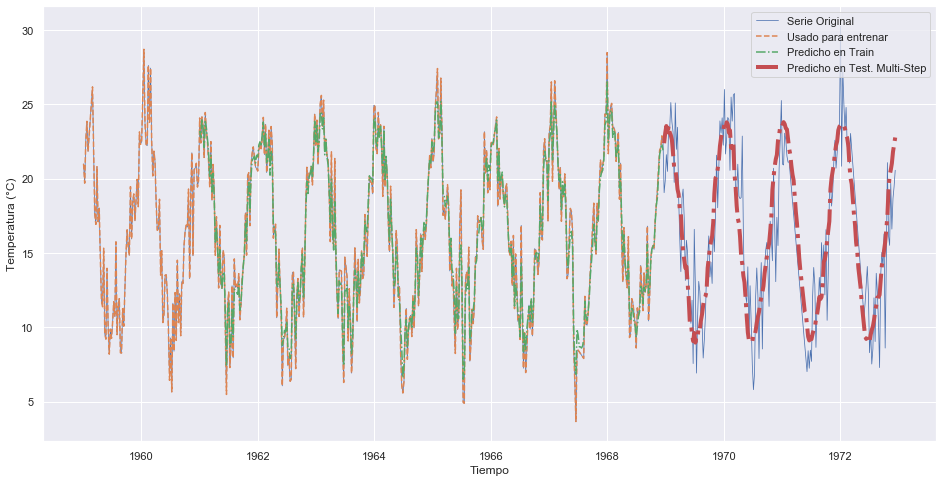

In [32]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.show()

Y calculamos el error RMSE

In [34]:
MSE = mean_squared_error(y_test, y_ms_test_pred)
print('Error en Train:',np.sqrt(MSE))

Error en Train: 2.58738126728768


In [1]:
import pandas as pd
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

¿Qué les parece este resultado?¿Cuál es la diferencia con el One-Step predicton?

**Para pensar:** ¿qué otras formas - vistas durante la carrera - servirán para evaluar estos resultados?

## 3. Prophet

Instala y estudia las características de esta librería. Intenta utilizarla para obtener los componentes de la serie y para predecir. ¡Recuerda seguir la documentación!